# European Energy Price Prediction with ARIMA & SARIMA

### What is Time Series?
A time series is a sequence of data points collected, recorded, or measured at successive, evenly-spaced time intervals.
Each data point represents observations or measurements taken over time, such as stock prices, temperature readings, or sales figures. Time series data is commonly represented graphically with time on the horizontal axis and the variable of interest on the vertical axis, allowing analysts to identify trends, patterns, and changes over time.

### Componenets of Time Series Data?
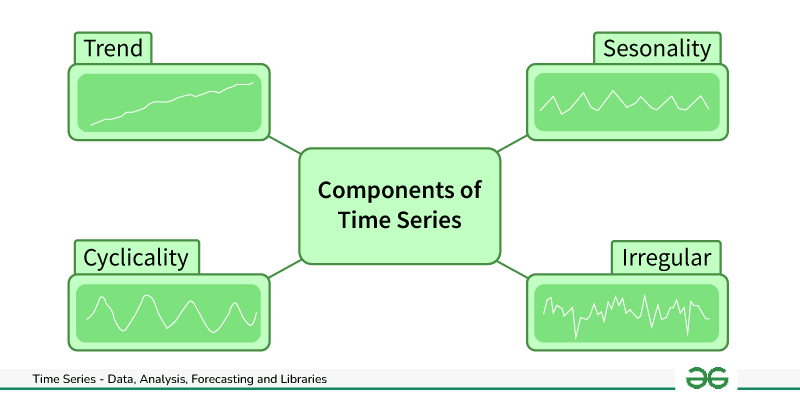
1. <b>Trend:</b> Trend represents the long-term movement or directionality of the data over time. It captures the overall tendency of the series to increase, decrease, or remain stable. Trends can be linear, indicating a consistent increase or decrease, or nonlinear, showing more complex patterns.
2. <b>Seasonality:</b> Seasonality refers to periodic fluctuations or patterns that occur at regular intervals within the time series. These cycles often repeat annually, quarterly, monthly, or weekly and are typically influenced by factors such as seasons, holidays, or business cycles.
3. <b>Cyclic variations:</b> Cyclical variations are longer-term fluctuations in the time series that do not have a fixed period like seasonality. These fluctuations represent economic or business cycles, which can extend over multiple years and are often associated with expansions and contractions in economic activity.
4. <b>Irregularity (or Noise):</b> Irregularity, also known as noise or randomness, refers to the unpredictable or random fluctuations in the data that cannot be attributed to the trend, seasonality, or cyclical variations. These fluctuations may result from random events, measurement errors, or other unforeseen factors. Irregularity makes it challenging to identify and model the underlying patterns in the time series data.

### Why Time Series Analysis is useful?
Time series analysis and forecasting are crucial for predicting future trends, behaviors, and behaviours based on historical data. It helps businesses make informed decisions, optimize resources, and mitigate risks by anticipating market demand, sales fluctuations, stock prices, and more. Additionally, it aids in planning, budgeting, and strategizing across various domains such as finance, economics, healthcare, climate science, and resource management, driving efficiency and competitiveness.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


from scipy import stats
import statsmodels.api as sm
from itertools import product

import plotly.graph_objects as go
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={"axes.facecolor":"beige" , "axes.grid" : False})

In [2]:
df = pd.read_csv(r"D:\UNH Materials\Projects\Energy Price Predictions\European Energy Market\data\EU_energy_data.csv")
df.head()

,Unnamed: 0,fecha,hora,sistema,bandera,precio,tipo_moneda,origen_dato,fecha_actualizacion
0,0,2010-07-21,1,HU,1,39.287,1,6,2021-10-01 12:39:53
1,1,2010-07-21,2,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2,2010-07-21,3,HU,1,33.223,1,6,2021-10-01 12:39:53
3,3,2010-07-21,4,HU,1,30.842,1,6,2021-10-01 12:39:53
4,4,2010-07-21,5,HU,1,33.395,1,6,2021-10-01 12:39:53


### Dataset Description
European energy markets are highly dynamic due to factors such as renewable energy integration, supply-demand balance, and geopolitical influences.
Hourly updates allow for real-time analysis, which is crucial for decision-making.
Understanding price fluctuations helps stakeholders optimize energy procurement and investment strategies.
Economic trends in the region impact energy pricing, making this dataset valuable for informed decision-making.
Feel free to explore this dataset further—it’s a goldmine for anyone interested in energy economics!


| Column name	| Description |
| :- | :- |
| fecha	| Date of the power prices in DD/MM/YYYY format. (Date) |
| hora	| Hour that corresponds with each set of power prices listed by minute. (Time) |
| sistema	| Numeric code for system identifier for each set of reported price points for a specific hour across EU countries. (Numeric) |
| bandera	| Indicator of whether or not electricity is green (Y) or non-green/conventional electricity (N). (Boolean)
| precio	| Cost per Megawatt Hour expressed in Euro €/MWh currency format. (Currency)
| tipo_moneda	| Euros represented as Euros € EUROSCURSUSD (EURS = US Dollars USD) as well as other available foreign currencies. (Currency)
| origen_dato	| Databases selected according to regional exchanges. (String)
| fecha_actualizacion	| Refers back to source DateTime objects entered inline at origin source databases. (DateTime)

In [3]:
df.shape

(1831555, 9)

In [4]:
df.isna().sum()

Unnamed: 0             0
fecha                  0
hora                   0
sistema                0
bandera                0
precio                 0
tipo_moneda            0
origen_dato            0
fecha_actualizacion    0
dtype: int64

In [5]:
# Rename Columns
df = df.rename(columns = {'fecha' : 'Date',
                          'hora' : 'Hour' , 
                          'sistema' : 'EU_countries',
                          'bandera' : 'Renewable/Non_Renewable',
                          'precio' : 'Cost(€/MWh)',
                          'tipo_moneda' : 'CurrencyType',
                          'origen_dato' : 'DataSource', 
                          'fecha_actualizacion' : 'Updated_Date'}
                )                                                
df = df.drop('Unnamed: 0',axis=1)

In [6]:
df.head()

,Date,Hour,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
0,2010-07-21,1,HU,1,39.287,1,6,2021-10-01 12:39:53
1,2010-07-21,2,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2010-07-21,3,HU,1,33.223,1,6,2021-10-01 12:39:53
3,2010-07-21,4,HU,1,30.842,1,6,2021-10-01 12:39:53
4,2010-07-21,5,HU,1,33.395,1,6,2021-10-01 12:39:53


In [7]:
df['EU_countries'].value_counts()

HU      100561
NO2      79079
SE3      79079
SE2      79079
SE1      79079
NO5      79079
NO4      79079
NO3      79079
NO1      79079
SYS      79079
LT       79079
GB       79079
FI       79079
DK1      79079
EE       79079
DK2      79079
SE4      79079
LV       75408
FR       70320
ES       70296
PT       70296
RS       51648
NL       22081
AT       22081
BE       22081
DE       22081
IT       15529
ELE       3671
CALA      2641
CNOR      2641
CSUD      2641
NORD      2641
SARD      2641
SICI      2641
SUD       2641
FRE       1751
Name: EU_countries, dtype: int64

In [8]:
# Merge Date and Hour columns
df['Hour'] = df['Hour'].astype(str).str.zfill(2)
try:
    df['Hour'] = pd.to_numeric(df['Hour'])
except:
    # Handle conversion errors (e.g., non-numeric characters)
    print("Error converting 'Hour' column to numeric")

# Function to convert the range
def convert_range(value):
    # Handle edge cases (leading zero and exceeding 24)
    if value == '01':
        return 0
    elif value > 24:
        raise ValueError("Value exceeds 24")
    else:
        # Remove leading zero (assuming strings) or subtract 1 (assuming integers)
        return int(value) - 1 if isinstance(value, int) else int(value[1:])

# Function to replace values with leading zeros (handles all cases)
def replace_with_leading_zero(value):
    if 0 <= value <= 23:
        return f"{value:02d}"  # Use f-string for consistent formatting
    else:
        raise ValueError(f"Value {value} is outside the range 0-12")

In [9]:
# Apply the function
df['Hour'] = df['Hour'].apply(convert_range)
df['Hour'] = df['Hour'].apply(replace_with_leading_zero)
df['Hour'] = df['Hour'].astype(str)  # Ensure Hour is string type
df['Hour'] = df['Hour'] + ':00:00'

df["Period"] = df[["Date","Hour"]].apply(" ".join, axis=1)

# Filter useful columns
df = df [['Period','EU_countries', 'Renewable/Non_Renewable',
       'Cost(€/MWh)', 'CurrencyType', 'DataSource', 'Updated_Date']]

df['Period'] = pd.to_datetime(df['Period'],format ="%Y-%m-%d %H:%M:%S" )
df.head()

,Period,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
0,2010-07-21 00:00:00,HU,1,39.287,1,6,2021-10-01 12:39:53
1,2010-07-21 01:00:00,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2010-07-21 02:00:00,HU,1,33.223,1,6,2021-10-01 12:39:53
3,2010-07-21 03:00:00,HU,1,30.842,1,6,2021-10-01 12:39:53
4,2010-07-21 04:00:00,HU,1,33.395,1,6,2021-10-01 12:39:53


In [10]:
# Let's Analyse a Specific Country = France
df_France = df[df['EU_countries']== "FR"]

# Remove the unnecessary feature
df_France = df_France.drop(['EU_countries','CurrencyType','DataSource','Updated_Date','Renewable/Non_Renewable'],axis=1)
df_France.head().style.set_properties(subset=['Period'], **{'background-color': 'yellow'})

,Period,Cost(€/MWh)
179166,2014-01-01 00:00:00,15.150000
179187,2014-01-01 01:00:00,12.960000
179208,2014-01-01 02:00:00,12.090000
179229,2014-01-01 03:00:00,11.700000
179250,2014-01-01 04:00:00,11.660000


In [11]:
# Creating a copy to keep original Dataset intact
France_df = df_France.copy('Deep')

In [12]:
df_France = df_France.set_index('Period')
df_France.sort_index(inplace=True)
df_France.head()

,Cost(€/MWh)
Period,
2014-01-01 00:00:00,15.15
2014-01-01 01:00:00,12.96
2014-01-01 02:00:00,12.09
2014-01-01 03:00:00,11.70
2014-01-01 04:00:00,11.66


# Exploratory Data Analysis and Visualization

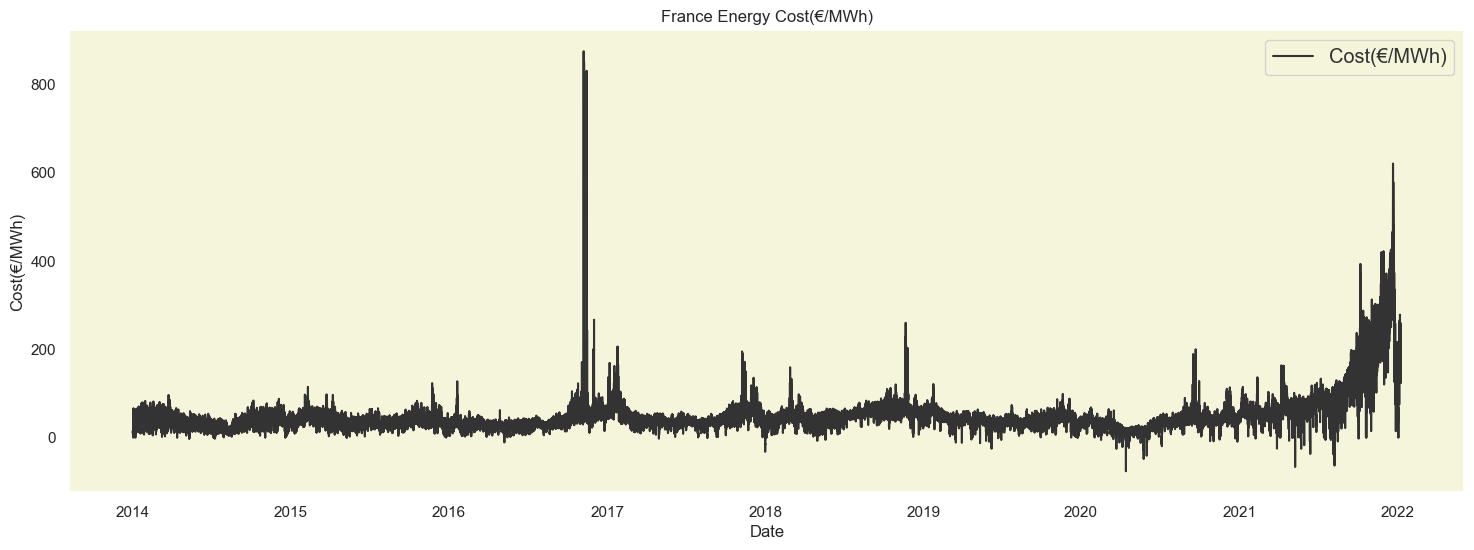

In [13]:
# Energy Cost over the period
plt.figure(figsize = (18,6))
plt.plot(df_France.index,df_France['Cost(€/MWh)'],label= 'Cost(€/MWh)',color = '#333')
plt.title('France Energy Cost(€/MWh)')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.grid(False)
plt.legend(labelcolor='#333', fontsize='large')
plt.show()

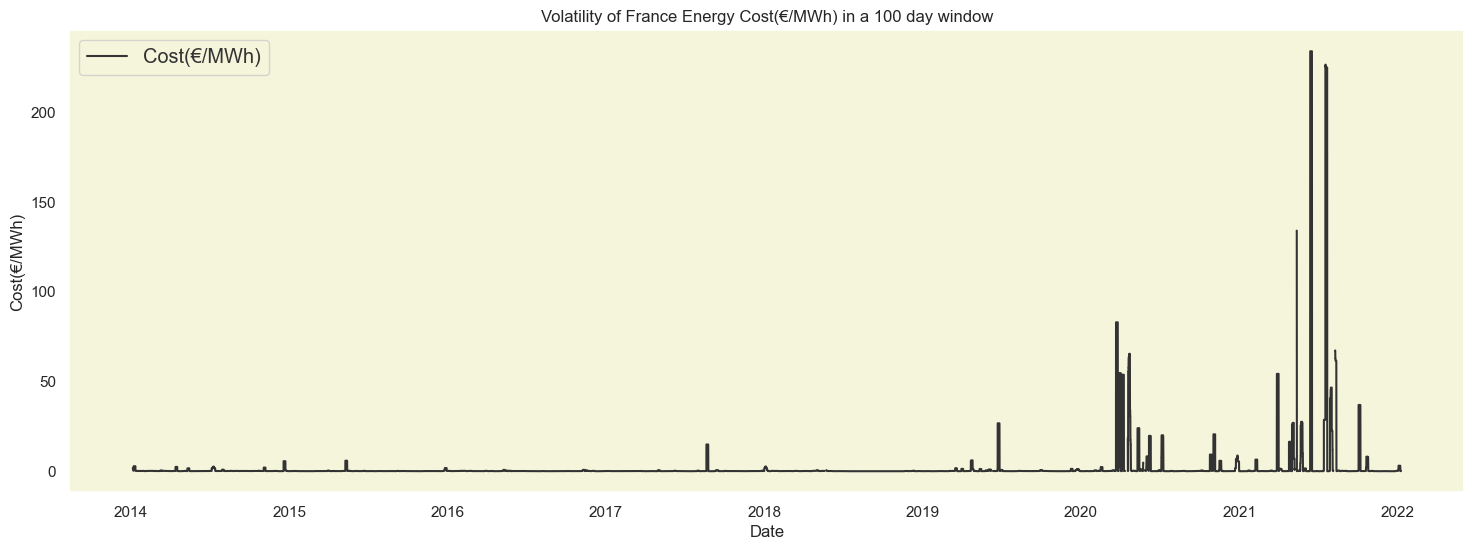

In [14]:
# Percent Change over a 100 time period window
df_France['Change'] = df_France['Cost(€/MWh)'].pct_change()
window_size = 100
df_100 = df_France['Change'].rolling(window = window_size).std()

#plotting
plt.figure(figsize = (18,6))
plt.plot(df_France.index , df_100 , label = 'Cost(€/MWh)' , color = '#333')
plt.title('Volatility of France Energy Cost(€/MWh) in a 100 day window')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend(labelcolor='#333', fontsize='large')
plt.grid(False)
plt.show()

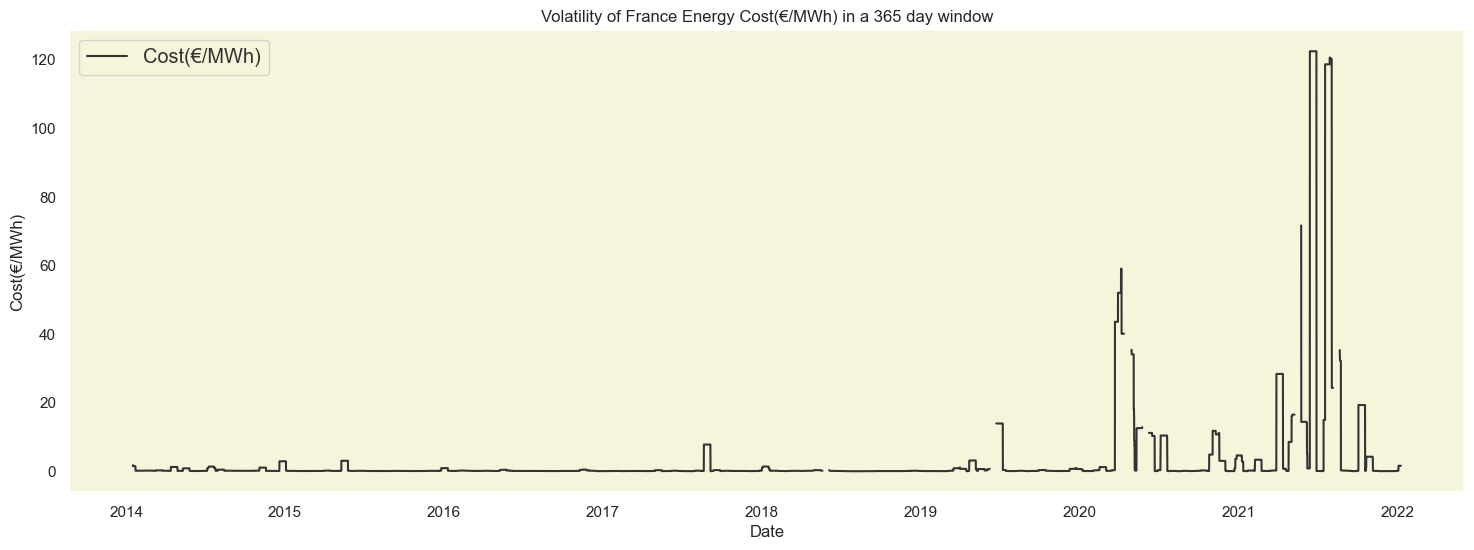

In [15]:
# Percent Change over a 365 day (Year) time period window
df_France['Change'] = df_France['Cost(€/MWh)'].pct_change()
window_size = 365
df_365 = df_France['Change'].rolling(window = window_size).std()

#plotting
plt.figure(figsize = (18,6))
plt.plot(df_France.index , df_365 , label = 'Cost(€/MWh)' , color = '#333')
plt.title('Volatility of France Energy Cost(€/MWh) in a 365 day window')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend(labelcolor='#333', fontsize='large')
plt.grid(False)
plt.show()

In [16]:
# Moving Average and Exponential Moving Average Over a period of 30 days
df_France['MA'] = df_France['Cost(€/MWh)'].rolling(window = 30).mean()
df_France['EMA'] = df_France['Cost(€/MWh)'].ewm(span = 30 , adjust = False).mean()

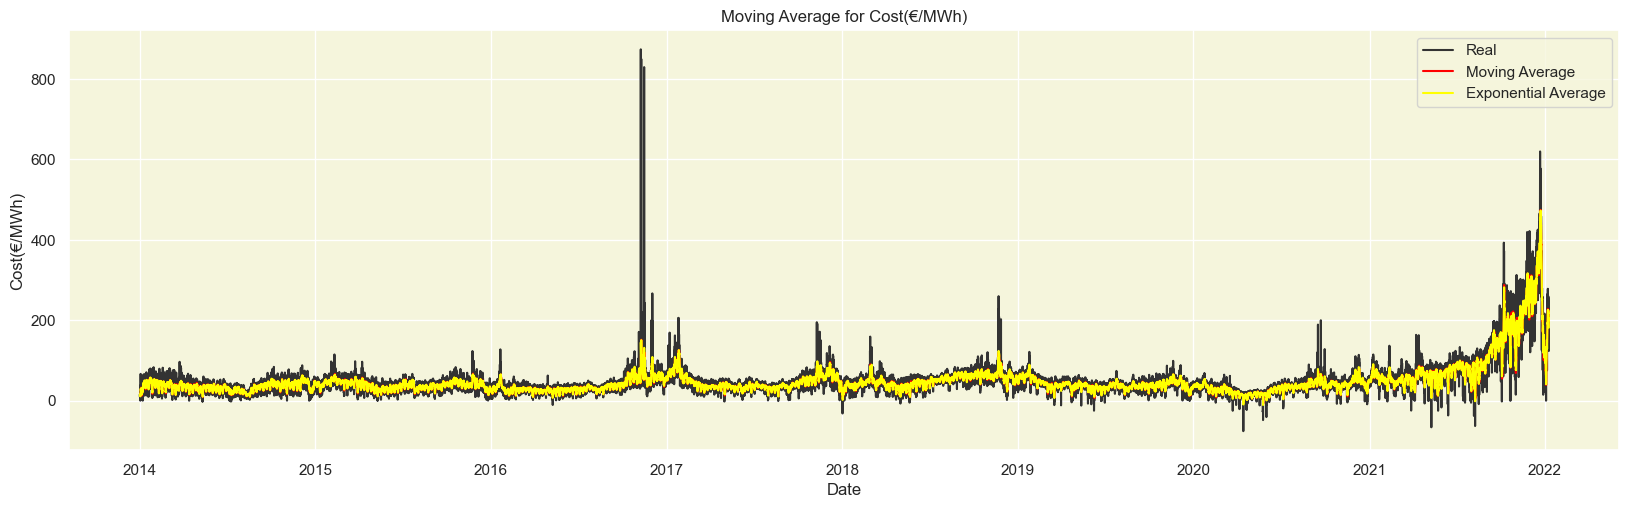

In [17]:
plt.figure(figsize = (20,12))

plt.subplot(2,1,1)
plt.plot(df_France.index,df_France['Cost(€/MWh)'], label = 'Real', color='#333')
plt.plot(df_France.index,df_France['MA'] , label = 'Moving Average' , color = 'red')
plt.plot(df_France.index,df_France['EMA'] , label = 'Exponential Average' , color = 'yellow')
plt.title('Moving Average for Cost(€/MWh)')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.grid()

In [ ]:
seasonal_decompose(df_France, period=365).plot()
plt.show();

In [18]:
# Now we will use France_df which we created earlier
France_df = France_df.set_index('Period')
France_df.head()

,Cost(€/MWh)
Period,
2014-01-01 00:00:00,15.15
2014-01-01 01:00:00,12.96
2014-01-01 02:00:00,12.09
2014-01-01 03:00:00,11.70
2014-01-01 04:00:00,11.66


# Augmented Dickey-Fuller (ADF) test
<b>Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not.</b>

In ARIMA time series forecasting, the first step is to determine the number of differencing required to make the series stationary.

Since testing the stationarity of a time series is a frequently performed activity in autoregressive models, the ADF test along with KPSS test is something that you need to be fluent in when performing time series analysis.

Another point to remember is the ADF test is fundamentally a statistical significance test. That means, there is a hypothesis testing involved with a null and alternate hypothesis and as a result a test statistic is computed and p-values get reported.

It is from the test statistic and the p-value, you can make an inference as to whether a given series is stationary or not.

### What is a Unit Root Test?
The ADF test belongs to a category of tests called ‘Unit Root Test’, which is the proper method for testing the stationarity of a time series.
Unit root is a characteristic of a time series that makes it non-stationary. Technically speaking, a unit root is said to exist in a time series of the value of alpha = 1 in the below equation.
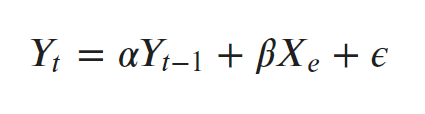
<i>where, Yt is the value of the time series at time ‘t’ and Xe is an exogenous variable (a separate explanatory variable, which is also a time series).</i>
What does this mean to us?

The presence of a unit root means the time series is non-stationary. Besides, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary.
    
### How does Augmented Dickey Fuller (ADF) Test work?
As the name suggest, the ADF test is an ‘augmented’ version of the Dickey Fuller test.

The ADF test expands the Dickey-Fuller test equation to include high order regressive process in the model.
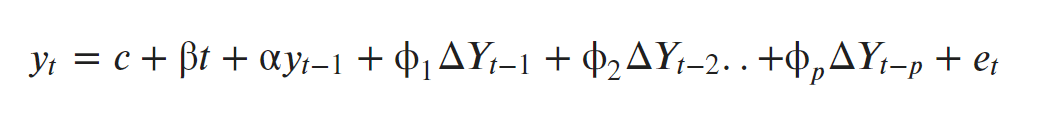
If you notice, we have only added more differencing terms, while the rest of the equation remains the same. This adds more thoroughness to the test.

The null hypothesis however is still the same as the Dickey Fuller test.

A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

However, this is a very common mistake analysts commit with this test. That is, if the p-value is less than significance level, people mistakenly take the series to be non-stationary.

In [19]:
result = adfuller(France_df['Cost(€/MWh)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("\n")
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -7.237777
p-value: 0.000000


Critial Values:
   1%, -3.430443076272825
Critial Values:
   5%, -2.8615811380624825
Critial Values:
   10%, -2.5667918963845726


The p-value is less than 0.05, hence we can reject the null hypothesis and take that the series is stationary.

# Auto Correlation Plot
### What is Autocorrelation?
Autocorrelation, also known as serial correlation, measures the relationship between a time series and a lagged version of itself over successive time intervals. Simply put, it tells you how similar the data points are to each other at different time lags.

Example: Imagine you are tracking the temperature of a city every day. If today’s temperature is similar to yesterday’s, and yesterday’s temperature is similar to the day before, we say that the temperature data is autocorrelated.

### The Autocorrelation Function (ACF)
The ACF plots the correlation of the time series with itself at different lags. This helps in identifying patterns such as seasonality, trends, and the persistence of values over time.

- Lag 1: Correlation between observations at time t and t−1
- Lag 2: Correlation between observations at time t and t−2
- And so on…

### Interpreting ACF Plots
When you look at an ACF plot, you’ll see bars at each lag. The height of the bar represents the correlation coefficient at that lag.

- Significant Lag: If a bar extends beyond the significance bounds, it indicates significant autocorrelation at that lag.
- Gradual Decline: A gradual decline in bar heights suggests a long-term dependency in the data.
- Seasonal Patterns: Regular spikes at certain lags suggest seasonality in the data.

### Partial Autocorrelation
Partial autocorrelation measures the correlation between observations at two time points, accounting for the values of the observations at all shorter lags. This helps isolate the direct relationship between observations at different lags, removing the influence of intermediary observations.

### The Partial Autocorrelation Function (PACF)
The PACF plot shows the partial correlation of the time series with itself at different lags.

### Interpreting PACF Plots
The PACF plot helps determine the order of an autoregressive model (AR model).

- Significant Lag: A significant spike at a particular lag suggests the inclusion of that lag in the AR model.
- Cut-off Point: The lag at which the PACF plot cuts off helps determine the maximum lag to include in the AR model.

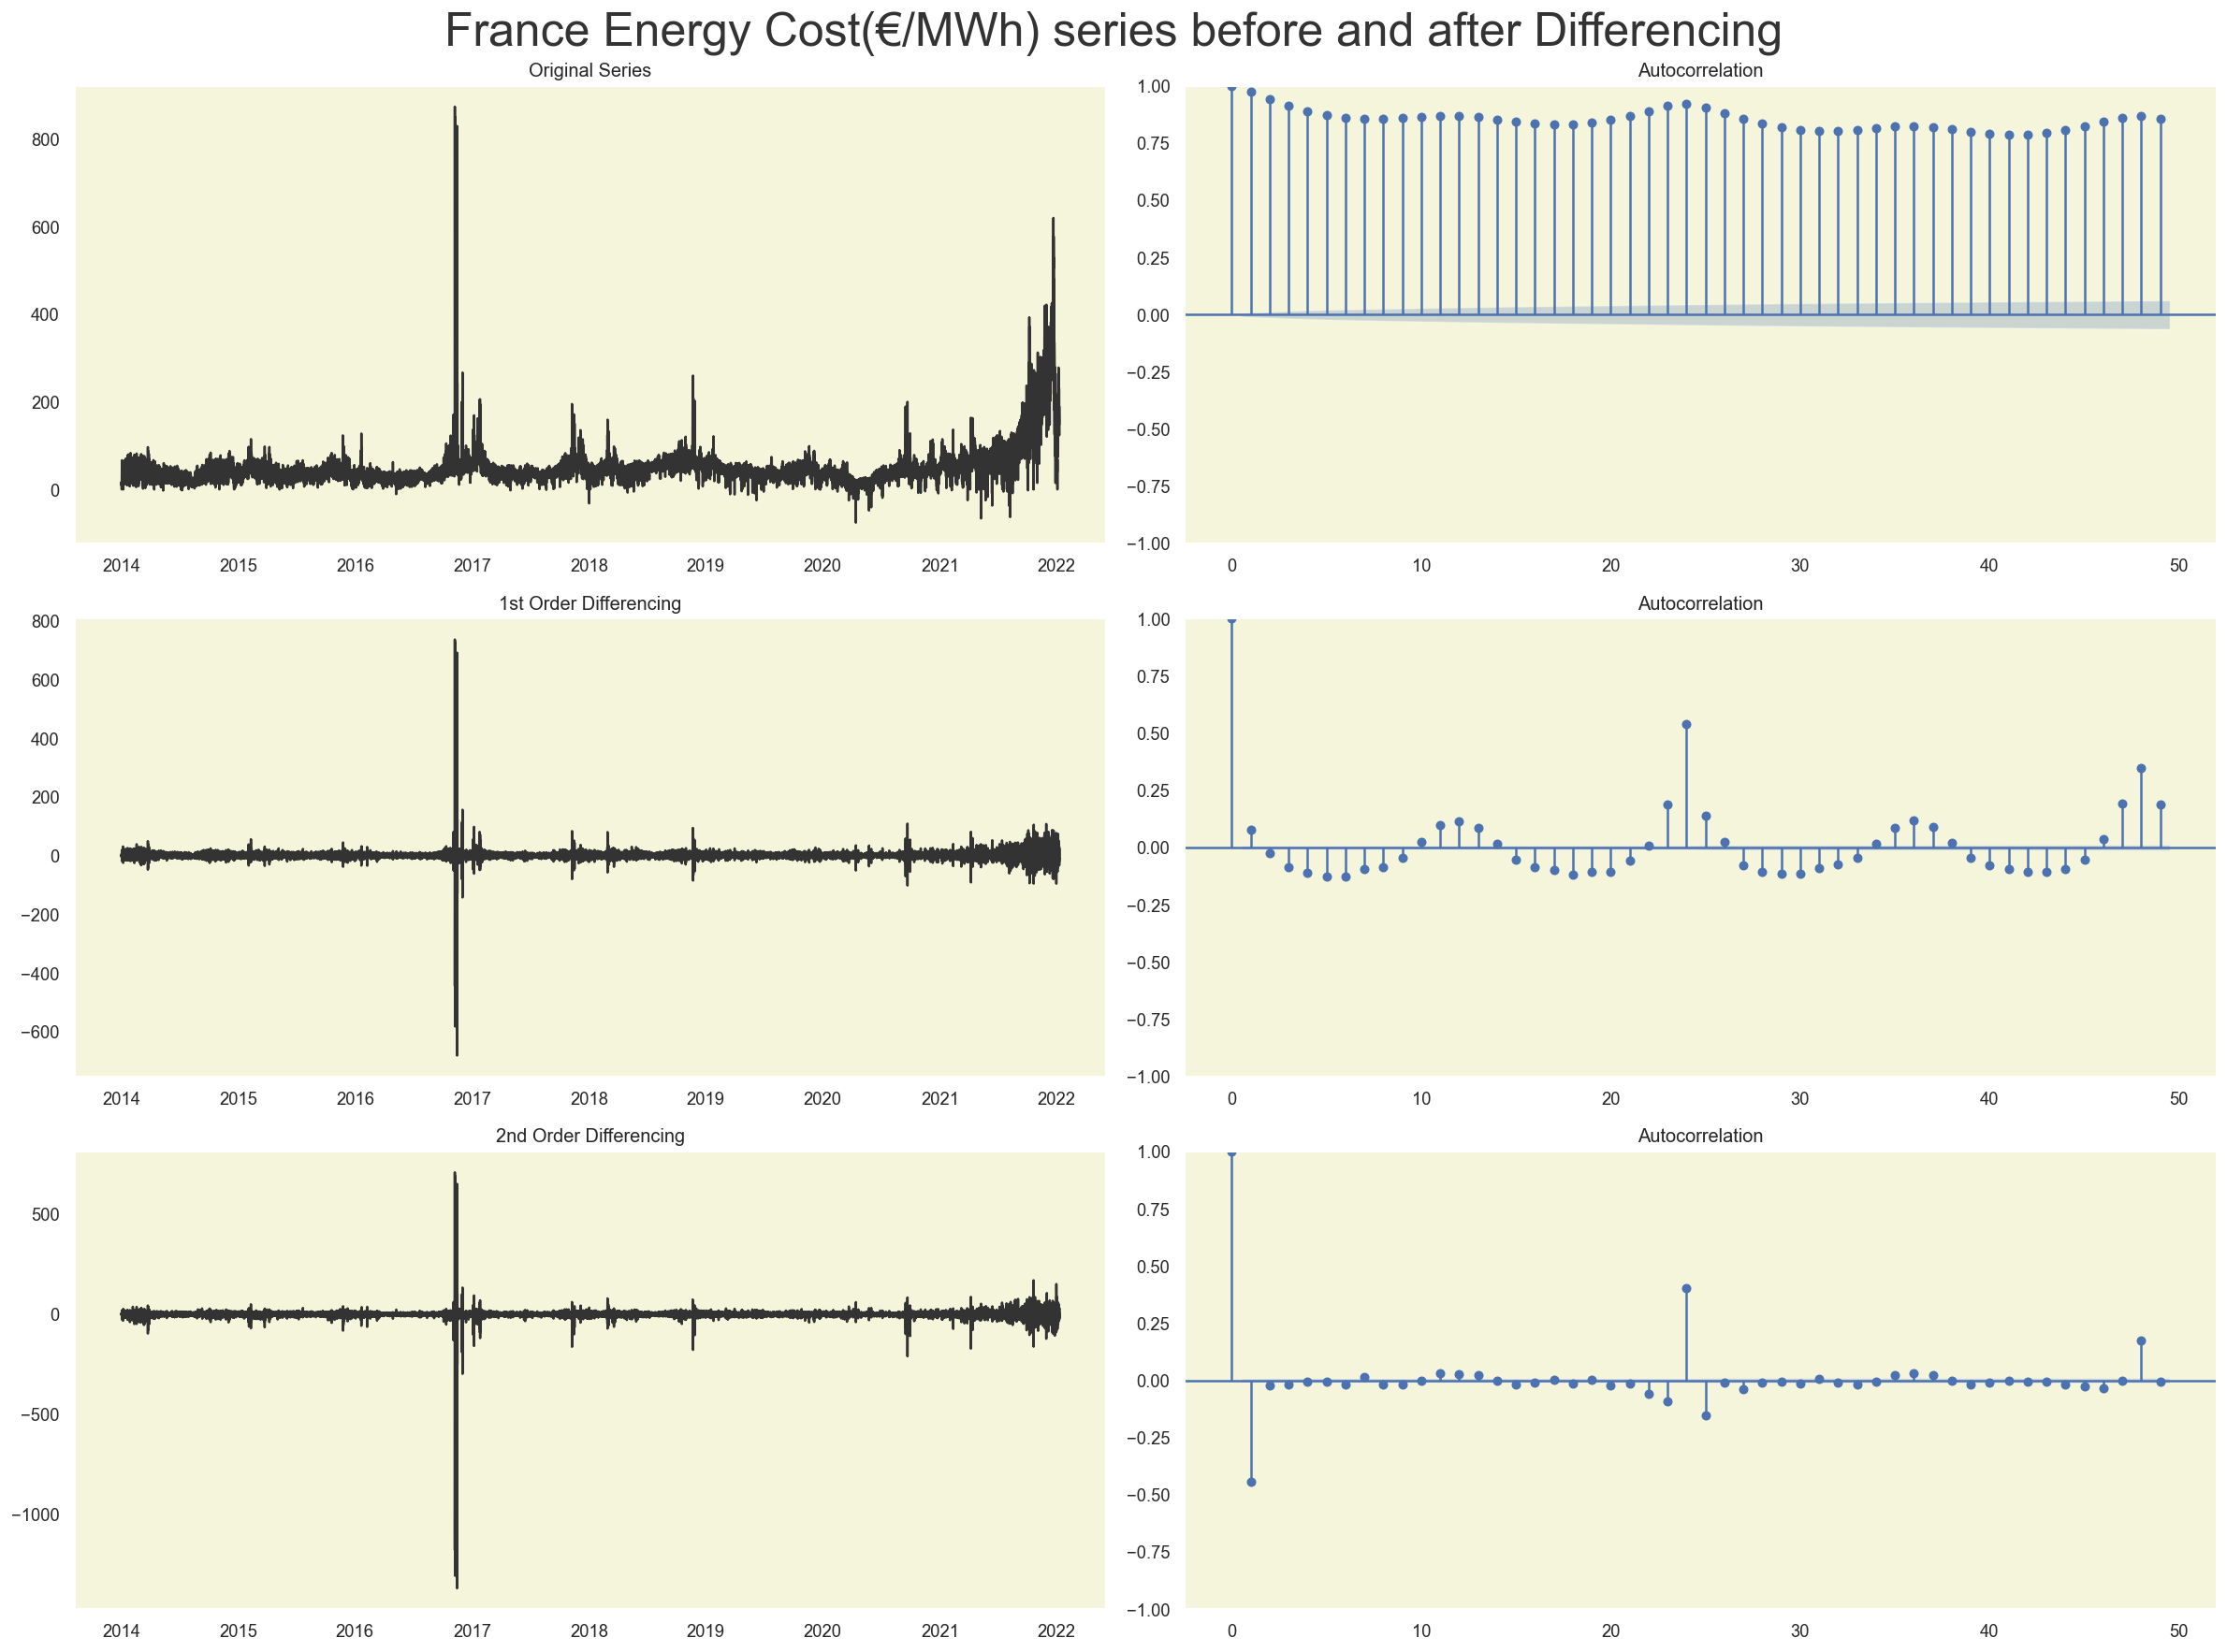

In [20]:
plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(France_df['Cost(€/MWh)'], color="#333")
axes[0, 0].set_title('Original Series')

# Plotting the ACF
plot_acf(France_df['Cost(€/MWh)'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(France_df['Cost(€/MWh)'].diff(), color="#333")
axes[1, 0].set_title('1st Order Differencing')
plot_acf(France_df['Cost(€/MWh)'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(France_df['Cost(€/MWh)'].diff().diff(), color="#333")
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(France_df['Cost(€/MWh)'].diff().diff().dropna(), ax=axes[2, 1])

plt.suptitle('France Energy Cost(€/MWh) series before and after Differencing', size = 30,color= '#333')
plt.tight_layout()

# fig.subplots_adjust(hspace=0.4)

plt.show()

The first order differencing ACF plot shows Sinusoidal curve which indicates Seasonality and Second order differencing ACF plot suggest a Cutoff value at order 2

# ARIMA Model

### ARIMA: A Time Machine for Predictions
ARIMA, standing for Autoregressive Integrated Moving Average, is a statistical model that empowers you to forecast future values based on past observations in a time series dataset. It's a popular choice for analyzing and predicting trends in various fields, from finance (stock prices) to weather forecasting (temperature variations).

### The Building Blocks of ARIMA:
ARIMA breaks down the time series into three key components:

1. Autoregressive (AR): This captures the influence of past values on the current value. Imagine predicting tomorrow's stock price; ARIMA considers the closing prices from the past few days (up to a specified order 'p') to make a prediction.

2. Integrated (I): Sometimes, data exhibits non-stationarity, meaning its characteristics (mean, variance) change over time. Differencing, a technique that removes the trend by subtracting the previous value from the current value, is applied (up to order 'd') to achieve stationarity.

3. Moving Average (MA): This component considers the impact of past forecast errors (up to order 'q') on the current prediction. Essentially, it incorporates the idea that errors from past predictions might influence future errors, helping to refine the forecast.

### Understanding the Notation:
ARIMA models are represented using the notation ARIMA(p, d, q), where:

- p signifies the number of autoregressive terms (past values considered).
- d indicates the degree of differencing needed to achieve stationarity.
- q represents the number of moving average terms (past forecast errors considered).

### Example: Predicting Sales Figures
Suppose you're a business analyst tasked with forecasting monthly sales. You might use an ARIMA model to analyze historical sales data. Here's a breakdown of a possible scenario:

- ARIMA(2, 1, 1): This model considers the influence of the past two months' sales figures (p=2) and incorporates differencing once (d=1) to remove any trends. Additionally, it takes into account the error from the previous month's forecast (q=1) to refine the current prediction.

### Strengths of ARIMA:
1. Effective for Stationary Data: ARIMA excels at analyzing and forecasting time series data that exhibits stationarity.
2. Relatively Straightforward Implementation: Compared to more complex models, ARIMA offers a good balance between accuracy and interpretability.
3. Wide Range of Applications: Its flexibility makes it applicable in various domains like finance, economics, and environmental science.

### Limitations to Consider:
1. Stationarity is a Must: The model's effectiveness relies heavily on the data being stationary. If not, transformations like differencing might be necessary.
2. Parameter Tuning is Crucial: Choosing the optimal values for p, d, and q can be an iterative process. Techniques like examining the autocorrelation function (ACF) and partial autocorrelation function (PACF) can assist in this selection.
3. Limited for Non-linear Relationships: ARIMA assumes a linear relationship between past observations and future values. If the relationship is non-linear, other models might be more suitable.

In conclusion, ARIMA serves as a powerful tool for time series forecasting, particularly when dealing with stationary data. Its interpretability and diverse applications make it a cornerstone technique in the data scientist's toolkit.

In [21]:
# First order differencing and ADF
result = adfuller(France_df.diff()['Cost(€/MWh)'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -43.063020
p-value: 0.000000


The value is lesser than the significance level of 0.05 and hence the series is stationary

                               SARIMAX Results                                
Dep. Variable:            Cost(€/MWh)   No. Observations:                70320
Model:                 ARIMA(5, 1, 2)   Log Likelihood             -254800.742
Date:                Sat, 02 Nov 2024   AIC                         509617.484
Time:                        18:16:37   BIC                         509690.770
Sample:                             0   HQIC                        509640.082
                              - 70320                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1481      0.043     26.804      0.000       1.064       1.232
ar.L2         -0.3223      0.039     -8.294      0.000      -0.398      -0.246
ar.L3         -0.0324      0.004     -7.561      0.0

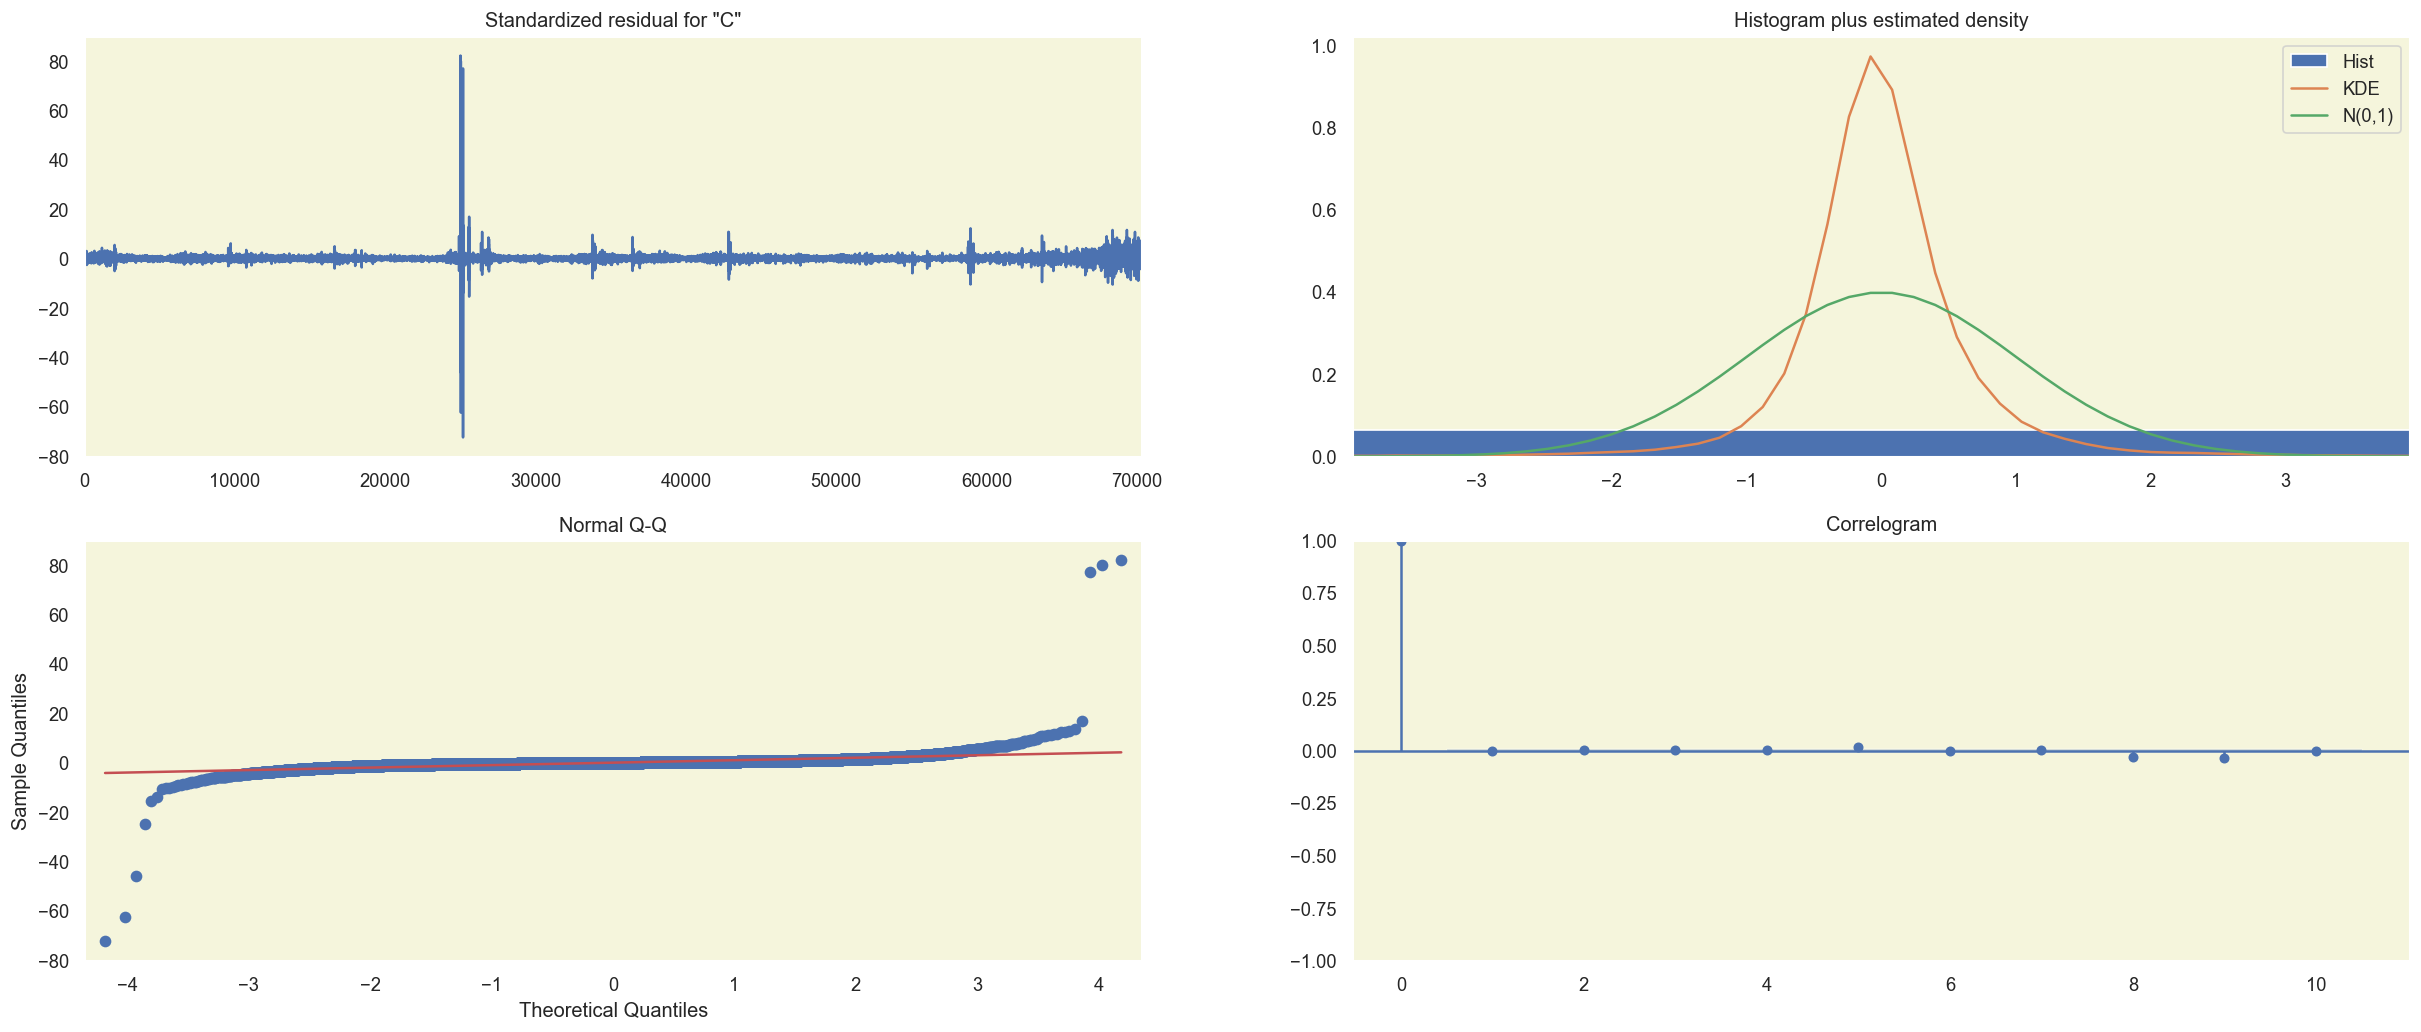

Mean Squared Error: 14578.474074856978


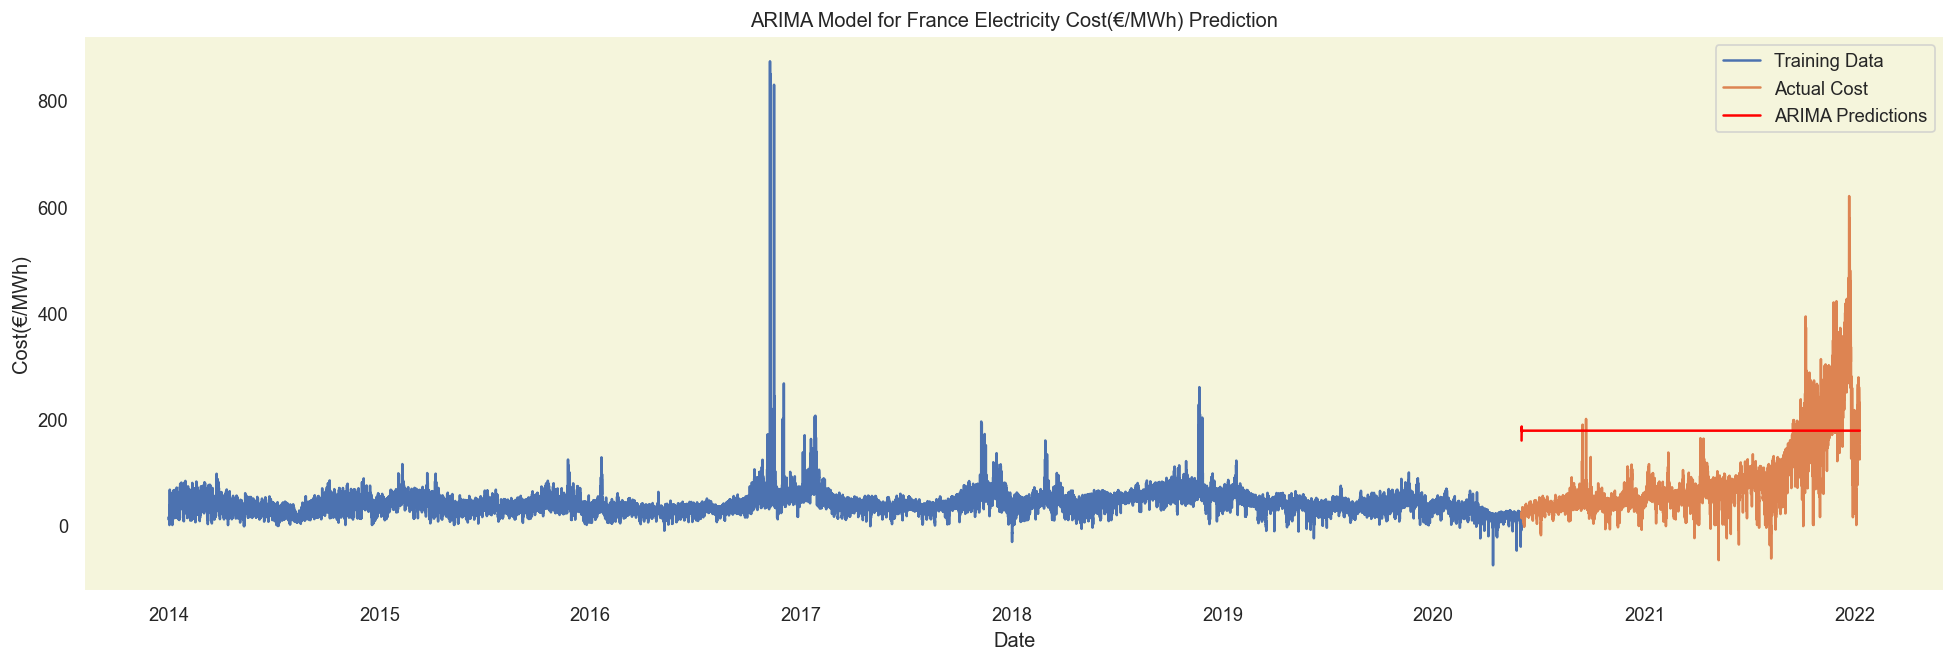

In [29]:
# train test split
train_size = int(len(France_df)*0.8)
train , test = France_df.iloc[:train_size] , France_df.iloc[train_size:]

p = 5  
d = 1
q = 2

model = ARIMA(France_df, order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot diagnostic plots
model_fit.plot_diagnostics(figsize=(25,10))
plt.show()

# Predictions
predictions = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Cost')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model for France Electricity Cost(€/MWh) Prediction')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.show()

### Interpretation of results
#### Model Summary:
- Dependent Variable: The model is fitted to the Cost(€/MWh) time series data.
- Observations: There are 70,320 data points used in the model fitting, which indicates a sufficiently large dataset.
#### Model Specifications:
- Order of the Model: ARIMA(5, 1, 2)
    - p = 5: This means that the model uses five lagged values of the dependent variable (autoregressive terms).
    - d = 1: The data was differenced once to achieve stationarity.
    - q = 2: The model includes two lagged forecast errors (moving average terms).
#### Model Fit Statistics:
- Log Likelihood: -254800.742, this value is used in calculating the information criteria and assessing the model's goodness of fit.
- AIC (Akaike Information Criterion): 509617.484; lower values indicate a better fit when comparing models. It suggests the balance between goodness of fit and complexity.
- BIC (Bayesian Information Criterion): 509690.770; similar to AIC but penalizes complexity more strongly. Again, lower values are preferable.
- HQIC (Hannan-Quinn Information Criterion): 509640.082; another criterion for model selection.
#### Coefficients:
- AR Terms:
    - ar.L1 (1.1481): Positive and statistically significant (p-value < 0.001). This suggests that the first lag has a strong positive influence on the current value.
    - ar.L2 (-0.3223): Negative and statistically significant, indicating that the second lag has a negative impact.
    - The subsequent AR terms (ar.L3, ar.L4, ar.L5) show diminishing influence, with decreasing coefficients and all statistically significant.
- MA Terms:
    - ma.L1 (-1.1695): Strong negative effect and statistically significant, indicating that past forecast errors (one lag back) have a substantial influence.
    - ma.L2 (0.2321): Positive effect and statistically significant, showing a smaller but meaningful impact from two lags of the error term.
#### Error Term:
- sigma2 (82.1958): The estimated variance of the error term, indicating the average level of variability in the model.
#### Diagnostics:
- Ljung-Box Test: Tests for autocorrelation in residuals.
    - Ljung-Box Q: 0.00 with a p-value of 0.96 suggests that there is no significant autocorrelation in the residuals; this is a good sign indicating that the model adequately captures the autocorrelation structure in the data.
- Jarque-Bera Test: Tests for normality of residuals.

    - The extremely high value indicates non-normality in the residuals (p-value = 0.00), suggesting that the residuals may be skewed or have high kurtosis, which could indicate potential model misspecification or the presence of outliers.
- Heteroskedasticity: The value of 3.91 with a p-value of 0.00 indicates significant heteroskedasticity, suggesting that the variance of the residuals is not constant over time, which could affect the reliability of the inference made from the model.

#### Conclusion:
The ARIMA(5, 1, 2) model fits your time series data reasonably well, with significant AR and MA coefficients suggesting a complex underlying structure in the time series. However, the diagnostics indicate some issues, particularly regarding the normality and constant variance of residuals. You may want to explore model adjustments or transformations to address these issues, such as using a different differencing strategy, adding seasonal components, or exploring Generalized Autoregressive Conditional Heteroskedasticity (GARCH) models if volatility clustering is present. Overall, the model provides a solid foundation for further refinement and application in forecasting the Cost(€/MWh).

# SARIMA Model

### SARIMA for Time Series Forecasting
In the realm of time series analysis, predicting future values from past observations is a constant pursuit. SARIMA (Seasonal Autoregressive Integrated Moving Average) emerges as a powerful tool for this task, particularly for data exhibiting seasonality.

### What is SARIMA?
SARIMA is a statistical model that builds upon the ARIMA (Autoregressive Integrated Moving Average) model by incorporating a seasonal component. It leverages past observations (AR), potential differencing to achieve stationarity (I), and past errors (MA) to make predictions, all while accounting for seasonal patterns (seasonal AR, seasonal differencing, and seasonal MA).

### Key Components of SARIMA:
- Non-seasonal AR (p): This captures the influence of past values (up to p lags) on the current value.
- Differencing (d): Differencing is applied if the data exhibits non-stationarity (trend or increasing/decreasing variance). It removes the trend by subtracting the previous value from the current value.
- Non-seasonal MA (q): This considers the impact of past forecast errors (up to q lags) on the current value.
- Seasonal AR (P): Similar to non-seasonal AR, this captures the influence of past seasonal values (e.g., past year's values for monthly data).
- Seasonal Differencing (D): Similar to differencing, this removes seasonal trends if present.
- Seasonal MA (Q): This considers the impact of past seasonal forecast errors on the current value.
- Seasonality (s): This specifies the number of periods in a single season (e.g., s=12 for monthly data).

### $$SARIMA(p, d, q)(P, D, Q)m$$

### Example: Predicting Electricity Prices
Imagine you're tasked with forecasting electricity prices. Electricity usage often exhibits seasonality, with higher demand during peak summer and winter months. A SARIMA model can be a good fit for this scenario.

Here's a simplified example:

You might choose a model with p=2 (considering the influence of the past two days' prices), d=1 (differencing to remove trends), q=1 (accounting for the previous day's forecast error). Additionally, you might include seasonal components like P=1 (considering the influence of the same day last month's price) and s=12 (accounting for monthly seasonality). By analyzing past electricity prices and fitting the SARIMA model with these parameters, you can generate forecasts for future electricity prices.

### Benefits of SARIMA:
- Effective for Seasonal Data: It excels at capturing and predicting trends in data with seasonal patterns.
- Relatively Easy to Implement: Compared to more complex models, SARIMA offers a good balance of accuracy and interpretability.
- Provides Model Diagnostics: The model can be assessed to identify potential shortcomings and refine its parameters for better results.

### Limitations of SARIMA:
- Requires Stationary Data: The model assumes stationarity in the data. If trends or non-constant variance exist, differencing might be needed.
- Parameter Tuning Can Be Challenging: Choosing the optimal hyperparameters (p, d, q, P, D, Q, s) can be an iterative process. Techniques like ACF and PACF analysis can help guide this process.
- Overall, SARIMA is a versatile tool for time series forecasting, particularly when dealing with seasonal data. Its interpretable nature and effectiveness make it a valuable weapon in the arsenal of data scientists and analysts.

                                      SARIMAX Results                                       
Dep. Variable:                          Cost(€/MWh)   No. Observations:                56256
Model:             SARIMAX(5, 1, 2)x(1, 1, [1], 12)   Log Likelihood             -192646.646
Date:                              Sat, 02 Nov 2024   AIC                         385313.292
Time:                                      18:29:38   BIC                         385402.667
Sample:                                           0   HQIC                        385341.136
                                            - 56256                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3531      0.000  -1077.303      0.000      -0.354      -0.352
ar.L2          0.70

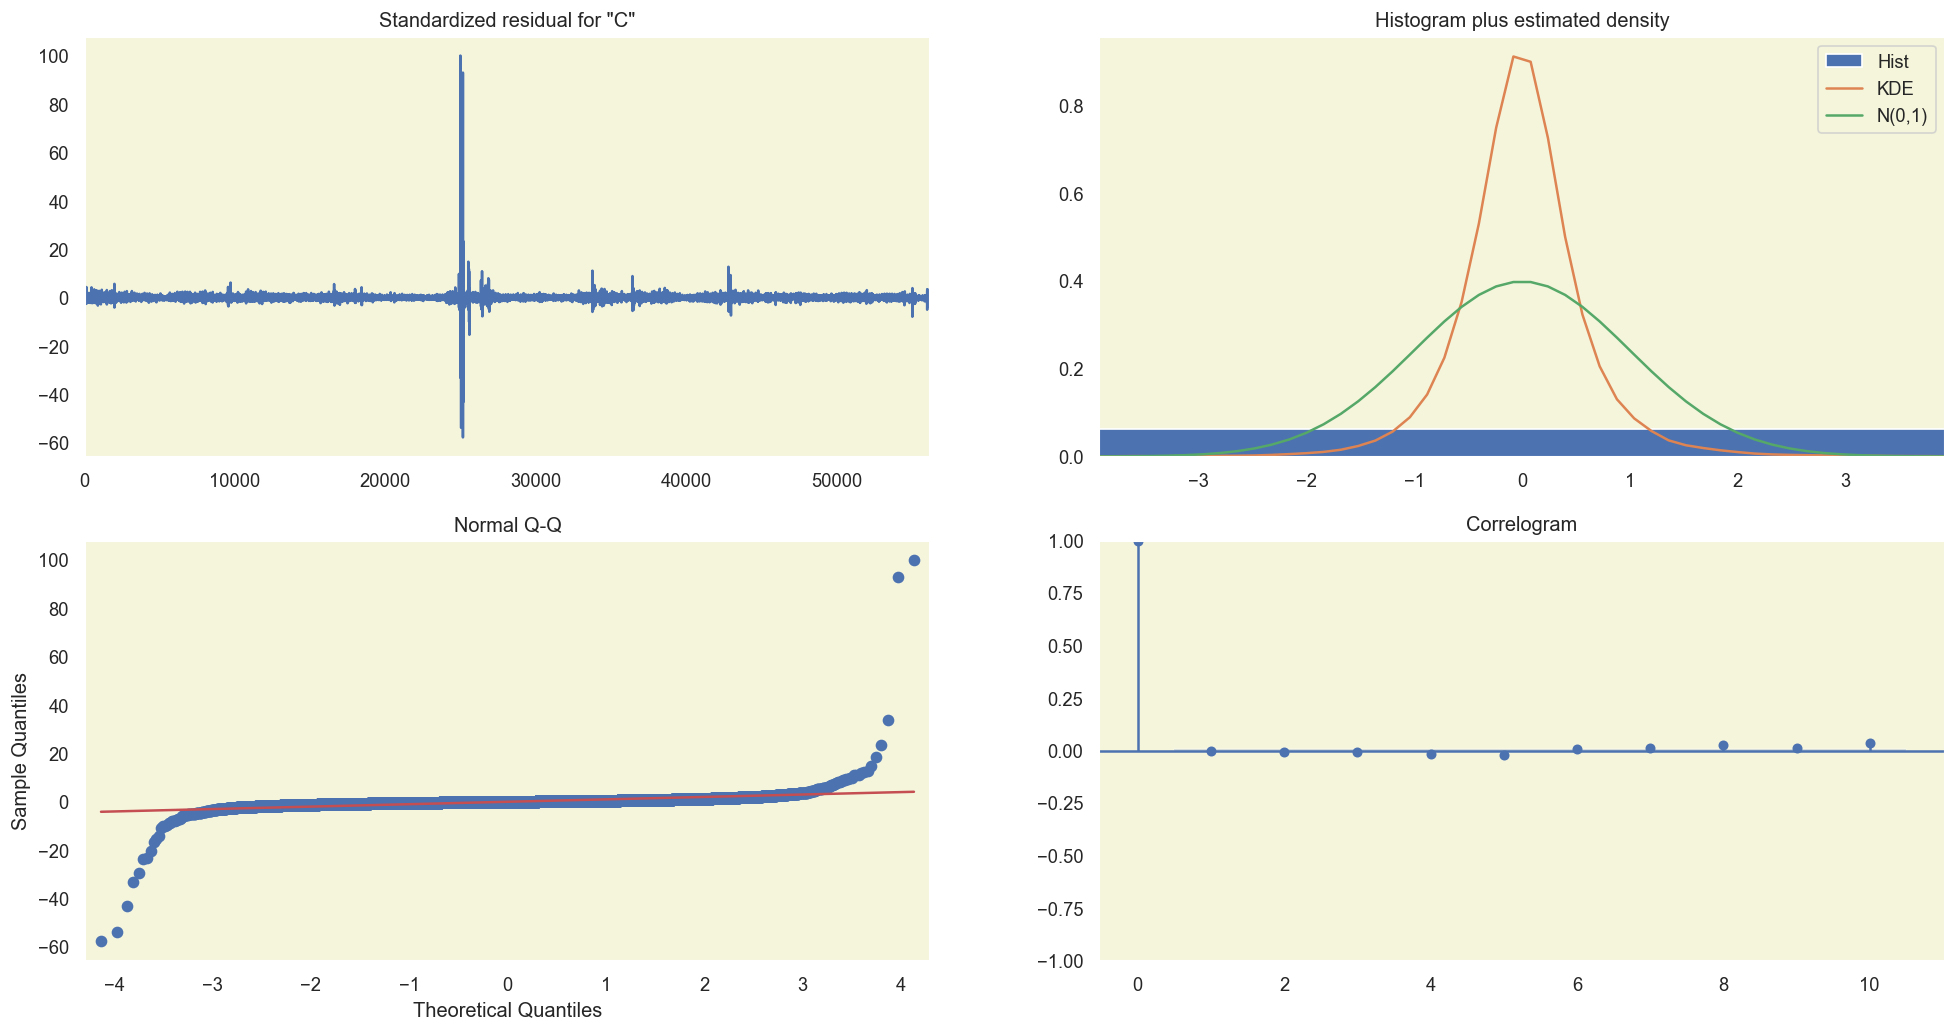

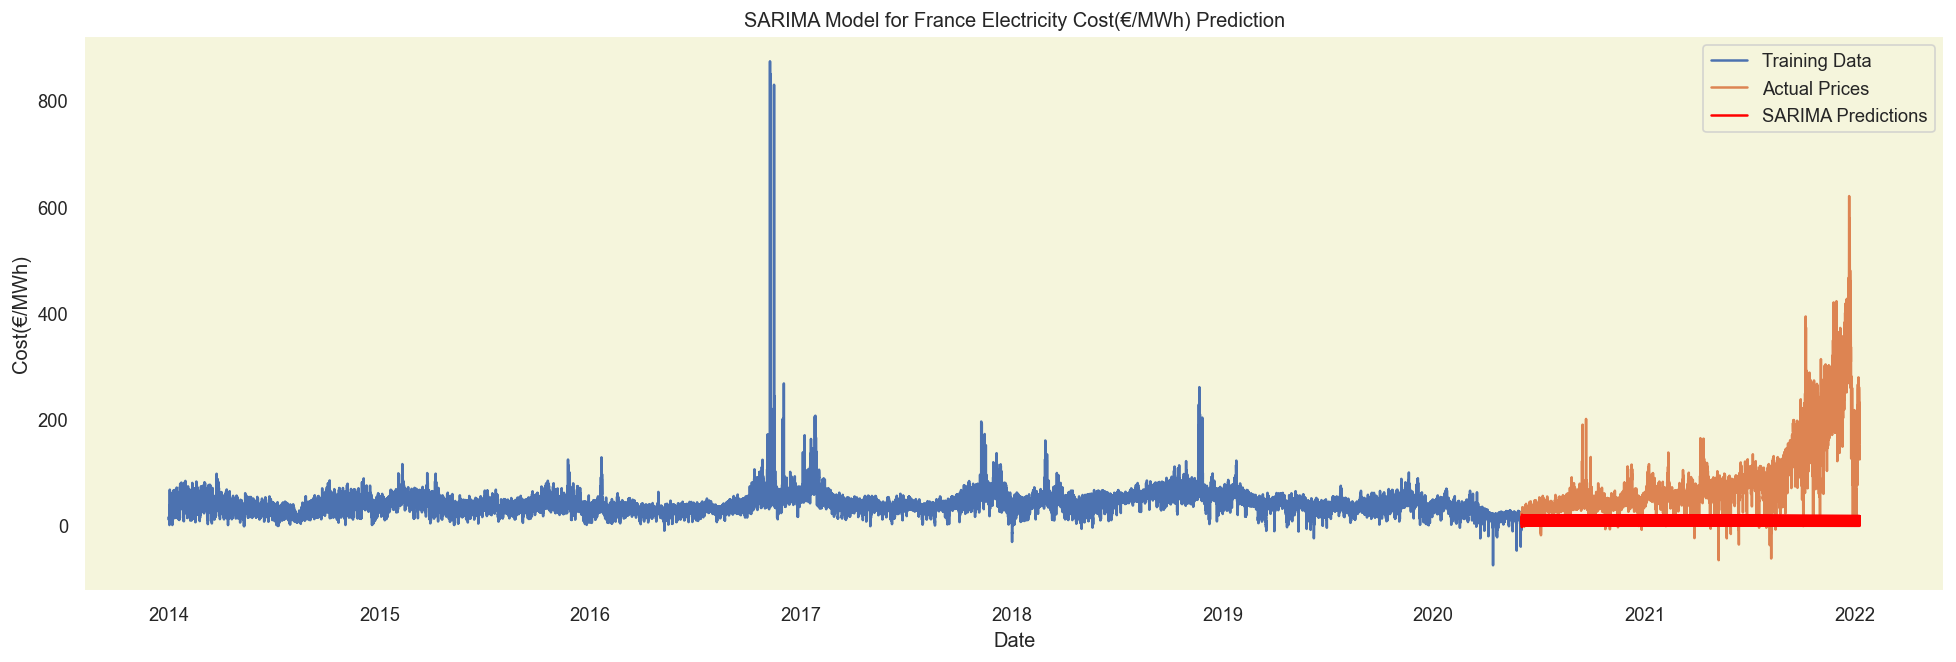

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Splitting data (assuming France_df is your data)
train_size = int(len(France_df) * 0.8)
train_2, test_2 = France_df.iloc[:train_size], France_df.iloc[train_size:]

# Define hyperparameters in a dictionary (easier to modify)
model_params = {
    'order': (5, 1, 2),  # Non-seasonal parameters (p, d, q)
    'seasonal_order': (1, 1, 1, 12),  # Seasonal parameters (P, D, Q, s)
}

# Build and fit the model in one step
sarimax_model = SARIMAX(train_2, **model_params).fit()

# Make predictions and calculate MSE
predictions_sarimax = sarimax_model.forecast(steps=len(test_2))
mse = mean_squared_error(test_2, predictions)

print(sarimax_model.summary())

sarimax_model.plot_diagnostics(figsize=(20, 10))
plt.show()

# Plot results (adjust figure size as needed)
plt.figure(figsize=(20, 6))
plt.plot(train_2, label='Training Data')
plt.plot(test_2, label='Actual Prices')
plt.plot(test_2.index, predictions_sarimax, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model for France Electricity Cost(€/MWh) Prediction')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.show()

### Interpretation of results
#### Model Summary:
- Dependent Variable: The model is fitted to the Cost(€/MWh) time series data.
- Observations: There are 56,256 data points used in the model fitting, which indicates a sufficiently large dataset.
#### Model Specifications:
- Order of the Model: SARIMAX(5, 1, 2)x(1, 1, [1], 12)
    - Non-seasonal Parameters:
        - p = 5: Five lagged values of the dependent variable (autoregressive terms).
        - d = 1: Data was differenced once to achieve stationarity.
        - q = 2: Two lagged forecast errors (moving average terms).
    - Seasonal Parameters:
        - P = 1: One seasonal autoregressive term.
        - D = 1: Seasonal differencing was applied once.
        - Q = 1: One seasonal moving average term.
        - s = 12: Seasonal period, suggesting monthly seasonality (12 months).
#### Model Fit Statistics:
- Log Likelihood: -192646.646, which indicates how well the model fits the data.
- AIC (Akaike Information Criterion): 385313.292; lower values suggest a better-fitting model.
- BIC (Bayesian Information Criterion): 385402.667; similar to AIC but penalizes complexity more heavily. Again, lower values are preferable.
- HQIC (Hannan-Quinn Information Criterion): 385341.136; another criterion for model selection.

#### Coefficients:
- AR Terms:
    - ar.L1 (-0.3531): Negative and statistically significant (p-value < 0.001), indicating a negative influence from the first lag.
    - ar.L2 (0.7092): Positive and significant, showing a strong positive influence from the second lag.
    - ar.L3 (0.1344), ar.L4 (0.1014), ar.L5 (0.0676): All are positive and significant, suggesting diminishing positive influences from higher lags.
- MA Terms:
    - ma.L1 (-0.0008): Not statistically significant (p-value = 0.980), indicating it may not contribute meaningfully to the model.
    - ma.L2 (-0.9992): Strong negative effect and significant, indicating a substantial influence from the second lag of the forecast error.
- Seasonal Terms:
    - ar.S.L12 (-0.6354): Significant negative influence from the seasonal autoregressive term, indicating that past seasonal values negatively affect the current value.
    - ma.S.L12 (-0.2557): Significant negative influence from the seasonal moving average term, suggesting the recent seasonal forecast errors also negatively affect current values.

#### Error Term:
- sigma2 (55.2534): The estimated variance of the error term, indicating the average level of variability in the model.
#### Diagnostics:
- Ljung-Box Test: Tests for autocorrelation in residuals.
    - Ljung-Box Q: 0.24 with a p-value of 0.63 indicates no significant autocorrelation in the residuals, suggesting a well-fitted model.
- Jarque-Bera Test: Tests for normality of residuals.
    - The very high value indicates non-normality in the residuals (p-value = 0.00), suggesting skewness and/or kurtosis issues, which could indicate potential model misspecification or the presence of outliers.
- Heteroskedasticity: The value of 1.07 with a p-value of 0.00 indicates significant heteroskedasticity, suggesting that the variance of the residuals is not constant over time, which can affect inference reliability.

#### Conclusion:
The SARIMAX(5, 1, 2)x(1, 1, 1, 12) model captures both non-seasonal and seasonal components of your time series data effectively, as indicated by the significant coefficients for both AR and seasonal terms. The model seems to account for seasonal effects and the patterns in the data, particularly with the seasonal autoregressive and moving average terms. However, similar to the ARIMA model, the diagnostics suggest issues with normality and constant variance of residuals. You might want to consider additional transformations, such as Box-Cox transformation, or further refining the model to account for these issues, as they can affect the reliability of predictions and the interpretation of the model results. Overall, the model provides a robust framework for understanding and forecasting the Cost(€/MWh) data while highlighting areas for improvement.